In [3]:
%load_ext Cython

In [4]:
import copy
import igraph
import json
import cairo
import pandas as pd
import sys
import numpy as np
import string
import random
import matplotlib.pyplot as plt 
import collections
%matplotlib inline

In [25]:

def make_board(n=7):
    board = set(range(1,n+1))
    return board

class GameNode:
    # def __init__(self, movein_player=2, board=make_board(), collected_points=[[],[],[]], sums=[0,0,0], moves=[], level=0):
    def __init__(self, movein_player=2, board=make_board(), sums=None, level=0):
        if not sums:
            sums = [sum(board), 0, 0]
            
        self.movein_player = movein_player
        self.moveout_player = 3-movein_player
        self.board = copy.copy(board)
        #self.collected_points = copy.deepcopy(collected_points)
        self.sums = [sums[0], sums[1], sums[2]]
        self.movein = []  # this is the move that got us to this node
        self.moves = []  # these are the possible moves after this node
        self.children = []
        self.level = level
        self.result = None
        self.vertexid = None
        self.graphed = False
        
    def spawn(self):
        # node= GameNode(self.movein_player, self.board, self.collected_points, self.sums)
        node= GameNode(self.movein_player, self.board, self.sums)
        node.result = self.result
        return node
        
    def show2(self, recursive=False):
        tab = "  "*self.level
        print(tab+"P"+str(self.moveout_player)+":"+str(self.board)+":"+str(self.sums)+" "+str(self.win()))
        if recursive:
            for child in self.children:
                child.show(recursive)
                
    def show(self, recursive=False):
        tab = "  "*self.level
        print(tab+"P"+str(self.movein_player)+""+str(self.movein)+":"+str(self.board)+":"+str(self.sums)+" "+str(self.result))
        if recursive:
            for child in self.children:
                child.show(recursive)
        
    def setmoves(self):
        self.moves = self.possible_moves()
        
    def push_move(self, move):
        # this is used for modifying a GameNode to a new state if you don't care about building a complete tree
        
        # swap in/out players
        self.movein_player, self.moveout_player = self.moveout_player, self.movein_player
        self.level += 1
        for m in move:
            self.board.discard(m)
            self.sums[self.movein_player] += m
            self.sums[0] -= m

    def pop_move(self, move):
        # this is used for modifying a GameNode to a new state if you don't care about building a complete tree
        
        # swap in/out players
        self.movein_player, self.moveout_player = self.moveout_player, self.movein_player
        self.level -= 1
        for m in move:
            self.board.add(m)
            self.sums[self.moveout_player] -= m
            self.sums[0] += m
        
    def make_key(self):
        return str(self.movein_player)+":"+str(self.sums[1])+'/'+str(self.sums[2])+":"+str(self.board)
    
    def make_move(self, move):
        node = self.spawn()
        node.movein_player = self.moveout_player
        node.moveout_player = self.movein_player
        
        #node.collected_points[node.movein_player].append(move)
        
        for pick in move:
            node.sums[node.movein_player] += pick
            node.sums[0] -= pick
            node.board.discard(pick)

        node.movein = move
        node.level = self.level + 1
    
        self.children.append(node)
        
        return node

    def generate_move(self, maxplay, sum_move=0, move=[], picks=None):
        if picks == None:
            picks = self.board

        if move:
            maxpick = max(move)
        else:
            maxpick = 0
            
        len_move_plus_1 = len(move)+1
        len_picks = len(picks)

        for pick in picks:
            if pick < maxpick:
                # only emit the moves in increasing order 
                # (i.e don't emit both 2,3 and 3,2 if you are behind by 4, just emit 2,3)
                continue

            if pick in move:
                # can't pick something you've already picked
                continue

            move.append(pick)
            if len_move_plus_1 == len_picks:
                yield list(move)
            elif sum_move+pick >= maxplay:
                yield list(move)
            else:
                for m in self.generate_move(maxplay, sum_move+pick, move, picks):
                    yield m
            move.pop()
            
    def generate_move2(self, maxplay, sum_move=0, move=[], picks=None, result=[]):
        if picks == None:
            picks = self.board

        if move:
            maxpick = max(move)
        else:
            maxpick = 0
            
        len_move_plus_1 = len(move)+1
        len_picks = len(picks)

        for pick in picks:
            if pick < maxpick:
                # only emit the moves in increasing order 
                # (i.e don't emit both 2,3 and 3,2 if you are behind by 4, just emit 2,3)
                continue

            if pick in move:
                # can't pick something you've already picked
                continue

            move.append(pick)
            if len_move_plus_1 == len_picks:
                result.append(list(move))
            elif sum_move+pick >= maxplay:
                result.append(list(move))
            else:
                self.generate_move2(maxplay, sum_move+pick, move, picks, result)
            move.pop()
            
    def generate_move3(self, maxplay, sum_move=0, move=[], istart = 0, picks=None):
        if picks == None:
            picks = list(self.board)
        
        len_move_plus_1 = len(move)+1
        len_picks = len(picks)
        
        if istart >= len_picks:
            return
        
        pick = picks[istart]
        # generate moves including the i'th number in picks
        move.append(pick)
        #print("gen with "+str(pick))
        if len_move_plus_1 == len_picks:
            # we've used up all the picks, so the turn is over
            #print("used all pieces: "+str(move))
            yield list(move)
        elif sum_move+pick >= maxplay:
            # we've exceeded the score, so the turn is over
            #print("maxplay: "+str(move))
            yield list(move)
        else:
            # generate all the moves that include this pick, and a combination of picks in the board
            # after this one
            for m in self.generate_move3(maxplay, sum_move+pick, move, istart+1, picks):
                yield m
        move.pop()
        #print("end: gen with "+str(pick))

        # generate moves not including the i'th number in picks
        #print("gen not "+str(pick))
        for m in self.generate_move3(maxplay, sum_move, move, istart+1, picks):
            yield m    
        #print("end: gen not "+str(pick))
        
    def generate_move4(self, maxplay, sum_move=0, move=[], istart = 0, picks=None, result=[]):
        if picks == None:
            picks = list(self.board)
        
        len_move_plus_1 = len(move)+1
        len_picks = len(picks)
        
        if istart >= len_picks:
            return
        
        pick = picks[istart]
        # generate moves including the i'th number in picks
        move.append(pick)
        #print("gen with "+str(pick))
        if len_move_plus_1 == len_picks:
            # we've used up all the picks, so the turn is over
            #print("used all pieces: "+str(move))
            result.append(list(move))
        elif sum_move+pick >= maxplay:
            # we've exceeded the score, so the turn is over
            #print("maxplay: "+str(move))
            result.append(list(move))
        else:
            # generate all the moves that include this pick, and a combination of picks in the board
            # after this one
            self.generate_move4(maxplay, sum_move+pick, move, istart+1, picks, result)
            
        move.pop()
        #print("end: gen with "+str(pick))

        # generate moves not including the i'th number in picks
        #print("gen not "+str(pick))
        self.generate_move4(maxplay, sum_move, move, istart+1, picks, result)
        #print("end: gen not "+str(pick))

    def scoreP1(self):
        sA = self.sums[1]
        sB = self.sums[2]
        return sA-sB
    
    def win(self):
        s = self.score()
        if s < 0:
            return -1
        elif s > 0:
            return 1
        else:
            return 0
    
    def winP1(self):
        s = self.scoreP1()
        if s < 0:
            return -1
        elif s > 0:
            return 1
        else:
            return 0
    
    def score(self):
        sA = self.sums[self.movein_player]
        sB = self.sums[self.moveout_player]
        return sA-sB
    
    
    
    def possible_moves(self):
        # A is the current player
        # B is the opponent player
        sA = self.sums[self.moveout_player]
        sB = self.sums[self.movein_player]

        maxplay = sB - sA
        #assert maxplay >= 0

        moves = list(self.generate_move(maxplay))
        return moves
    
    def possible_moves2(self):
        # A is the current player
        # B is the opponent player
        sA = self.sums[self.moveout_player]
        sB = self.sums[self.movein_player]

        maxplay = sB - sA
        #assert maxplay >= 0
    
        moves = []
        self.generate_move2(maxplay, result=moves)
        return moves
    
    def possible_moves3(self):
        # A is the current player
        # B is the opponent player
        sA = self.sums[self.moveout_player]
        sB = self.sums[self.movein_player]

        maxplay = sB - sA
        #assert maxplay >= 0

        moves = list(self.generate_move3(maxplay))
        return moves
    
    def possible_moves4(self):
        # A is the current player
        # B is the opponent player
        sA = self.sums[self.moveout_player]
        sB = self.sums[self.movein_player]

        maxplay = sB - sA
        #assert maxplay >= 0
    
        moves = []
        self.generate_move4(maxplay, result=moves)
        return moves
    
        

In [27]:
g = GameNode(board=make_board(10))
g.push_move([10])
%timeit g.possible_moves()
%timeit g.possible_moves2()
%timeit g.possible_moves3()
%timeit g.possible_moves4()

10000 loops, best of 3: 119 µs per loop
10000 loops, best of 3: 114 µs per loop
10000 loops, best of 3: 189 µs per loop
10000 loops, best of 3: 147 µs per loop


## playing the game - heuristics
we need to play the game with different heuristics to discover which is most interesting

In [96]:
class Strategy:
    def __init__(self):
        pass
    
    def PickMove(self, node):
        return []
    
class RandomStrategy(Strategy):
    def __init__(self):
        pass
    
    def PickMove(self, node):
        moves = node.possible_moves()
        move = random.choice(moves)
        return move
    
class MaximizeScoreStrategy(Strategy):
    def __init__(self):
        pass
    
    def _DoPickMove(self, moves):
        movesum = [sum(move) for move in moves]
        target = max(movesum)
        indices = [i for i, x in enumerate(movesum) if x == target]
        index = random.choice(indices)
        return moves[index]
    
    def PickMove(self, node):
        moves = node.possible_moves()
        return self._DoPickMove(moves)


class MinimizeScoreStrategy(Strategy):
    def __init__(self):
        pass
    
    def _DoPickMove(self, moves):
        movesum = [sum(move) for move in moves]
        target = min(movesum)
        indices = [i for i, x in enumerate(movesum) if x == target]
        index = random.choice(indices)
        return moves[index]
    
    def PickMove(self, node):
        moves = node.possible_moves()
        return self._DoPickMove(moves)
    
class UseMostPiecesStrategy(Strategy):
    def __init__(self):
        pass
    
    def _DoPickMove(self, moves):
        movesum = [len(move) for move in moves]
        target = max(movesum)
        indices = [i for i, x in enumerate(movesum) if x == target]
        index = random.choice(indices)
        return moves[index]
    
    def PickMove(self, node):
        moves = node.possible_moves()
        return self._DoPickMove(moves)

class UseMostPiecesThenMaximizeStrategy(Strategy):
    def __init__(self):
        pass
    
    def _DoPickMove(self, moves):
        movelen = [len(move) for move in moves]
        movesum = [sum(move) for move in moves]
        target = max(movelen)
        indices = [i for i, x in enumerate(movesum) if x == target]
        if len(indices) == 1:
            return moves[indices[0]]
        else:
            movesummax =0
        
            for index in indices:
                movesummax = max(movesummax, movesum[index])
                
        index = random.choice(indices)
        return moves[index]
    
    def PickMove(self, node):
        moves = node.possible_moves()
        return self._DoPickMove(moves)
    
class UseLeastPiecesStrategy(Strategy):
    def __init__(self):
        pass
    
    def _DoPickMove(self, moves):
        movesum = [len(move) for move in moves]
        target = min(movesum)
        indices = [i for i, x in enumerate(movesum) if x == target]
        index = random.choice(indices)
        return moves[index]
    
    def PickMove(self, node):
        moves = node.possible_moves()
        return self._DoPickMove(moves)


    
class GamePlayer:
    def __init__(self, player1strategy, player2strategy, n=7):
        self.n = n
        self.strategies = [None, player1strategy, player2strategy]
    
    def Play(self):
        game = GameNode(board= make_board(self.n))
        while game.board:
            player = game.moveout_player
            move = self.strategies[player].PickMove(game)
            game.push_move(move)
        return game.winP1()
    
    def Experiment(self, n=10000):
        data = pd.Series([self.Play() for i in xrange(n)])
        return data.value_counts()
    

## Playing Against a Random Strategy
What is the best thing to do against a random strategy?

First, lets see what is the best heursitic when playing against a Random P2

In [83]:
GamePlayer(MinimizeScoreStrategy(), RandomStrategy(), 9).Experiment()

-1    5888
 1    4112
dtype: int64

In [84]:
GamePlayer(RandomStrategy(), RandomStrategy(), 9).Experiment()

 1    5006
-1    4994
dtype: int64

In [85]:
GamePlayer(MaximizeScoreStrategy(), RandomStrategy(), 9).Experiment()

 1    6058
-1    3942
dtype: int64

So, P1 prefers Maximize if playing against Random.  We can now assume that P2 switches to a new strategy since P1 is going to play Maximize. 


In [86]:
GamePlayer(MaximizeScoreStrategy(), MinimizeScoreStrategy(), 9).Experiment()

 1    7839
-1    2161
dtype: int64

In [87]:
GamePlayer(MaximizeScoreStrategy(), RandomStrategy(), 9).Experiment()

 1    5995
-1    4005
dtype: int64

In [88]:
GamePlayer(MaximizeScoreStrategy(), MaximizeScoreStrategy(), 9).Experiment()

-1    10000
dtype: int64

P2 thus moves to Maximize to match P1, and now P2 is always winning

In [92]:
GamePlayer(MaximizeScoreStrategy(), MaximizeScoreStrategy(), 9).Experiment()

-1    10000
dtype: int64

In [89]:
GamePlayer(RandomStrategy(), MaximizeScoreStrategy(), 9).Experiment()

-1    6582
 1    3418
dtype: int64

In [91]:
GamePlayer(MinimizeScoreStrategy(), MaximizeScoreStrategy(), 9).Experiment()

-1    6612
 1    3388
dtype: int64

In [95]:
GamePlayer(UseMostPiecesStrategy(), MaximizeScoreStrategy(), 9).Experiment()

-1    6181
 1    3819
dtype: int64

In [97]:
GamePlayer(UseLeastPiecesStrategy(), MaximizeScoreStrategy(), 9).Experiment()

-1    6804
 1    3196
dtype: int64

P2 seems to do very well with the maximize strategy with 1...9.  What about other games?

In [110]:
df = pd.DataFrame(index=[4,5,6,7,8,9,10], columns=[-1,0,1])
for i in df.index:
    df.loc[i] = GamePlayer(MinimizeScoreStrategy(), MaximizeScoreStrategy(), i).Experiment()
df

,-1,0,1
4,10000,NaN,NaN
5,10000,NaN,NaN
6,4987,NaN,5013
7,5058,NaN,4942
8,10000,NaN,NaN
9,6658,NaN,3342
10,2051,NaN,7949


In [76]:
s1 = MinimizeScoreStrategy()
s2 = MinimizeScoreStrategy()
gp = GamePlayer(s1, s2, 9)
gp.Experiment()

1    10000
dtype: int64

In [78]:
s1 = MinimizeScoreStrategy()
s2 = RandomStrategy()
gp = GamePlayer(s1, s2, 9)
gp.Experiment()

-1    5883
 1    4117
dtype: int64

In [79]:
s1 = MinimizeScoreStrategy()
s2 = MaximizeScoreStrategy()
gp = GamePlayer(s1, s2, 9)
gp.Experiment()

-1    6710
 1    3290
dtype: int64

In [80]:
s1 = MaximizeScoreStrategy()
s2 = MinimizeScoreStrategy()
gp = GamePlayer(s1, s2, 9)
gp.Experiment()

 1    7861
-1    2139
dtype: int64

In [81]:
s1 = MaximizeScoreStrategy()
s2 = MaximizeScoreStrategy()
gp = GamePlayer(s1, s2, 9)
gp.Experiment()

-1    10000
dtype: int64

In [ ]:
s1 = RandomStrategy()
s2 = RandomStrategy()
gp = GamePlayer(s1, s2, 9)
gp.Experiment()

In [57]:
class FastTreeExplore:
    def __init__(self, n=4):
        self.n = n
        self.root = GameNode(board=make_board(n))
    
    def num_nodes(self):
        def _explore(node):
            n = 1
            for move in node.possible_moves():
                node.push_move(move)
                n += _explore(node)
                node.pop_move(move)
            return n
        return _explore(self.root)
    
    def avg_branching_factor(self):
        d = {'count': 0, 'sumbranch': 0, 'maxbranch':0, 'avgbranch':0}
        def _explore(node):
            moves = node.possible_moves()
            len_moves = len(moves)
            if len_moves == 0:
                return 
            else:
                d['count'] += 1
                d['sumbranch'] += len_moves
                d['maxbranch'] = max(d['maxbranch'], len_moves)
                for move in moves:
                    node.push_move(move)
                    _explore(node)
                    node.pop_move(move)
        _explore(self.root)
        d['avgbranch'] = float(d['sumbranch'])/d['count']
        return d
    
       
    def random_play(self):
        node = self.root
        while True:
            moves = node.possible_moves()
            if not moves:
                # gameover
                break
            else:
                # more moves
                move = random.choice(moves)
                node.push_move(move)
                
        # return result from perspective of P1
        result = node.winP1()
        return result
   
    def count_win_lose_draw(self):
        wld = {'WIN':0,'LOSE':0,'TIE':0,'TOTAL':0}
               
        def _explore(node):
            moves = node.possible_moves()
            if not moves:
                win = node.winP1()
                if win == 1:
                    wld['WIN'] += 1
                elif win == -1:
                    wld['LOSE'] += 1
                elif win == 0:
                    wld['TIE'] += 1
                wld['TOTAL'] += 1
            else:
                for move in moves:
                    node.push_move(move)
                    _explore(node)
                    node.pop_move(move)
        _explore(self.root)
        
        wld['WIN%']  = float(wld['WIN'])/wld['TOTAL']
        wld['LOSE%']  = float(wld['LOSE'])/wld['TOTAL']
        wld['TIE%']  = float(wld['TIE'])/wld['TOTAL']
        
        return wld
    
    def count_win_lose_draw_cached(self):
        wld = {'WIN':0,'LOSE':0,'TIE':0,'TOTAL':0}
        cache = {}
               
        def _explore(node):
            key = node.make_key()
            
            # we've been here before, return the cached value
            if cache.has_key(key):
                return cache[key]
            
            
            result = np.array((0,0,0,0))
            moves = node.possible_moves()
            if not moves:
                win = node.winP1()
                if win == 1:
                    return np.array((1,0,0,1))
                elif win == -1:
                    return np.array((0,1,0,1))
                elif win == 0:
                    return np.array((0,0,1,1))
            else:
                for move in moves:
                    node.push_move(move)
                    result += _explore(node)
                    node.pop_move(move)
            cache[key] = result
            return result
        
        result = _explore(self.root)
        
        wld['WIN'] = result[0]
        wld['LOSE'] = result[1]
        wld['TIE'] = result[2]
        wld['TOTAL'] = result[3]
        wld['WIN%']  = float(wld['WIN'])/wld['TOTAL']
        wld['LOSE%']  = float(wld['LOSE'])/wld['TOTAL']
        wld['TIE%']  = float(wld['TIE'])/wld['TOTAL']
        
        return wld
    
    def find_duplicates(self):
        d = collections.defaultdict(int)
        
        def _explore(node):
            key = node.make_key()
            d[key] += 1
            d['TOTAL'] += 1
            
            moves = node.possible_moves()
            if not moves:
                return 
            else:
                for move in moves:
                    node.push_move(move)
                    _explore(node)
                    node.pop_move(move)
        _explore(self.root)
        
        return d
    
    def unique_states(self):
        cache = collections.defaultdict(int)
        
        def _explore(node):
            key = node.make_key()
            if cache.has_key(key):
                return
            else:
                cache[key] += 1
                cache['TOTAL'] += 1
            
            moves = node.possible_moves()
            if not moves:
                return 
            else:
                for move in moves:
                    node.push_move(move)
                    _explore(node)
                    node.pop_move(move)
        _explore(self.root)
        
        return cache['TOTAL']
    
    def depth(self):
        d = {'min':99999, 'max':0}
        def _explore(node, depth):
            moves = node.possible_moves()
            if len(moves) == 0:
                d['min'] = min(d['min'], depth)
                d['max'] = max(d['max'], depth)
            else:
                for move in moves:
                    node.push_move(move)
                    _explore(node, depth+1)
                    node.pop_move(move)
        _explore(self.root, 0)
        return d
    
    def mindepth_bfs(self):
        queue = [self.root]
        iqueue = 0
        mindepth = 99999
        while iqueue < len(queue):
            node = queue[iqueue]
            iqueue += 1 # this avoids popping, we can just leave nodes in the queue but ignore them
            
            # only expand the node if we might find a better solution
            if node.level >= mindepth:
                continue
                
            # expand the node
            node.setmoves()
            
            for move in node.moves:
                child = node.make_move(move)
                if not child.board:
                    # found a terminal node, check its depth
                    mindepth = min(mindepth, child.level)
                else:
                    # not a terminal node, but only expand if its shallower than our shortest terminal game
                    if child.level < mindepth:
                        queue.append(child)
            
        return mindepth

    
    def mindepth_id(self):
        # use iterative deepening
        def _explore(node, depth, maxdepth):
            #if depth >= maxdepth:
            #    return maxdepth+1
            
            if node.sums[0] == 0:
                # found a game that ends at maxdepth, we are done
                return depth           
            elif depth+1 <= maxdepth:
                # haven't reached the maxdepth yet, keep looking
                moves = node.possible_moves()
                for move in moves:
                    node.push_move(move)
                    best = _explore(node, depth+1, maxdepth)
                    node.pop_move(move)
                    
                    if best <= maxdepth:
                        return best
                # if here, we didn't find anything
                return maxdepth+1
            else:
                # fail case, truncating
                return maxdepth+1
        
        for iterdepth in xrange(1, self.n+1):
            v = _explore(self.root, 0, iterdepth)
            if v <= iterdepth:
                return v
        
        return -1
    
    def mindepth(self):
        d = {'min':99999}
        def _explore(node, depth):
            moves = node.possible_moves()
            if not moves:
                d['min'] = min(d['min'], depth)
            elif d['min'] == depth+1:
                # already found a min, don't search deeper
                return 
            else:
                # haven't reached the min yet, keep looking
                for move in moves:
                    node.push_move(move)
                    _explore(node, depth+1)
                    node.pop_move(move)
                    
                    # if we found an end game we don't have to search the rest
                    if d['min'] == depth+1:
                        break
                        
        _explore(self.root, 0)
        return d['min']
 
    
    def num_terminals(self):
        def _explore(node):
            n = 0
            moves = node.possible_moves()
            if len(moves) == 0:
                n+=1
            else:
                for move in moves:
                    node.push_move(move)
                    n += _explore(node)
                    node.pop_move(move)
            return n
        return _explore(self.root)
    
        
    def num_terminals_cached(self):
        cache = collections.defaultdict(int)
        def _explore(node):
            n=0
            moves = node.possible_moves()
            if len(moves) == 0:
                n+=1
            else:
                for move in moves:
                    node.push_move(move)
                    key = node.make_key()
                    if cache.has_key(key):
                        n += cache[key]
                    else:
                        value = _explore(node)
                        n += value
                        cache[key] = value
                    node.pop_move(move)
            return n
        return _explore(self.root)
    
    def negamax(self):
        # negamax code ported from https://en.wikipedia.org/wiki/Negamax
        def _explore(node, depth, color):
            #node.show2()
            
            if depth == 0:
                return color * node.winP1()
            moves = node.possible_moves()
            if not moves:
                return color * node.winP1()

            bestValue = -100
            for move in moves:
                node.push_move(move)
                val = -_explore(node, depth-1, -color)
                node.pop_move(move)
                bestValue = max( bestValue, val )
            return bestValue
                  
        return _explore(self.root, self.n+1, 1)
    
    def negamax_cached(self):
        # negamax code ported from https://en.wikipedia.org/wiki/Negamax
        cache = collections.defaultdict(int)
        
        def _explore(node, depth, color):
            #node.show2()
            key = node.make_key()
            if cache.has_key(key):
                return cache[key]
            
            if depth == 0:
                cache[key] = color * node.winP1()
                return color * node.winP1()
            moves = node.possible_moves()
            if not moves:
                cache[key] = color * node.winP1()
                return color * node.winP1()

            bestValue = -100
            for move in moves:
                node.push_move(move)
                val = -_explore(node, depth-1, -color)
                node.pop_move(move)
                bestValue = max( bestValue, val )
            cache[key] = bestValue
            return bestValue
        
        return _explore(self.root, self.n+1, 1)
    
    
            

## Win Lose Draw ratios
These are the actual win lose and draw ratios, not sampled from random play

In [59]:
%timeit FastTreeExplore(8).count_win_lose_draw()

1 loops, best of 3: 283 ms per loop


In [60]:
%time FastTreeExplore(12).count_win_lose_draw_cached()

CPU times: user 4.12 s, sys: 21.9 ms, total: 4.14 s
Wall time: 4.14 s


{'LOSE': 86157509,
 'LOSE%': 0.42980564755108486,
 'TIE': 28078185,
 'TIE%': 0.14007093085739233,
 'TOTAL': 200456903,
 'WIN': 86221209,
 'WIN%': 0.43012342159152284}

In [71]:
df = pd.DataFrame(columns=['WIN', 'WIN%', 'LOSE', 'LOSE%', 'TIE', 'TIE%', 'TOTAL'], index=range(3,21))
for n in xrange(3, 21):
    %time v = FastTreeExplore(n).count_win_lose_draw_cached()
    print((n,v))
    df.loc[n] = v
win_lose_draw_table = df
win_lose_draw_table

CPU times: user 185 µs, sys: 60 µs, total: 245 µs
Wall time: 225 µs
(3, {'WIN': 1, 'LOSE': 1, 'TIE%': 0.6, 'LOSE%': 0.2, 'TIE': 3, 'TOTAL': 5, 'WIN%': 0.2})
CPU times: user 519 µs, sys: 152 µs, total: 671 µs
Wall time: 579 µs
(4, {'WIN': 6, 'LOSE': 7, 'TIE%': 0.35, 'LOSE%': 0.35, 'TIE': 7, 'TOTAL': 20, 'WIN%': 0.3})
CPU times: user 1.61 ms, sys: 437 µs, total: 2.05 ms
Wall time: 1.65 ms
(5, {'WIN': 47, 'LOSE': 49, 'TIE%': 0.0, 'LOSE%': 0.5104166666666666, 'TIE': 0, 'TOTAL': 96, 'WIN%': 0.4895833333333333})
CPU times: user 5.26 ms, sys: 1.76 ms, total: 7.03 ms
Wall time: 5.63 ms
(6, {'WIN': 261, 'LOSE': 259, 'TIE%': 0.0, 'LOSE%': 0.4980769230769231, 'TIE': 0, 'TOTAL': 520, 'WIN%': 0.5019230769230769})
CPU times: user 15.9 ms, sys: 2.75 ms, total: 18.7 ms
Wall time: 16.6 ms
(7, {'WIN': 1283, 'LOSE': 1275, 'TIE%': 0.22625529340592862, 'LOSE%': 0.3856624319419238, 'TIE': 748, 'TOTAL': 3306, 'WIN%': 0.3880822746521476})
CPU times: user 48.8 ms, sys: 321 µs, total: 49.1 ms
Wall time: 49.3 ms

,WIN,WIN%,LOSE,LOSE%,TIE,TIE%,TOTAL
3,1,0.2,1,0.2,3,0.6,5
4,6,0.3,7,0.35,7,0.35,20
5,47,0.4895833,49,0.5104167,0,0,96
6,261,0.5019231,259,0.4980769,0,0,520
7,1283,0.3880823,1275,0.3856624,748,0.2262553,3306
8,9578,0.3949691,9670,0.3987629,5002,0.206268,24250
9,101172,0.5008713,100820,0.4991287,0,0,201992
10,920208,0.4998346,920817,0.5001654,0,0,1841025
11,7776633,0.4240134,7784264,0.4244294,2779640,0.1515572,1.834054e+07
12,8.622121e+07,0.4301234,8.615751e+07,0.4298056,2.807818e+07,0.1400709,2.004569e+08


In [365]:
%time FastTreeExplore(9).negamax_cached()

CPU times: user 154 ms, sys: 3.75 ms, total: 158 ms
Wall time: 155 ms


-1

In [330]:
t = TreeBuilder(5)
t.build(cache=True)
t.calc_results()
-t.root.result

1

## Random Play

What are the odds of losing, winning, or tying given random play?

In [332]:
df = pd.DataFrame(columns=range(2,21), index=[-1,0,1])
n = 10000
for c in df.columns:
    df[c] = pd.Series([FastTreeExplore(c).random_play() for i in xrange(n)]).value_counts()
df = df.fillna(0)
df = df/n
random_win_lose_draw = df
random_win_lose_draw

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
-1,0.4977,0.1691,0.3306,0.53,0.5033,0.3899,0.3885,0.4985,0.5033,0.4342,0.4330,0.4974,0.5032,0.4476,0.4569,0.4968,0.5006,0.4546,0.4692
0,0.0000,0.6662,0.3558,0.00,0.0000,0.2239,0.2137,0.0000,0.0000,0.1397,0.1282,0.0000,0.0000,0.1035,0.0949,0.0000,0.0000,0.0812,0.0778
1,0.5023,0.1647,0.3136,0.47,0.4967,0.3862,0.3978,0.5015,0.4967,0.4261,0.4388,0.5026,0.4968,0.4489,0.4482,0.5032,0.4994,0.4642,0.4530


In [339]:
FastTreeExplore(7).random_play()

1

In [257]:
FastTreeExplore(4).negamax()

1

In [178]:
t = FastTreeExplore(8)
d = t.find_duplicates()
print((len(d)-1, d['TOTAL']))
t.unique_states()

(1453, 58111)


1453

In [80]:
def FindAvgBranchingFactor(n):
    t = FastTreeExplore(n)
    d = t.avg_branching_factor()
    return d

df = pd.DataFrame({'_n': range(3,11), 'avgbranch':0, 'count':0, 'maxbranch':0, 'sumbranch':0})
for i in df.index:
    n = df['_n'][i]
    d = FindAvgBranchingFactor(n)
    df.iloc[i] = (n, d['avgbranch'], d['count'], d['maxbranch'], d['sumbranch'])
    
#df['avgbranch'] = df['n'].apply(FindAvgBranchingFactor)
branching_factor_df = df
branching_factor_df

,_n,avgbranch,count,maxbranch,sumbranch
0,3,1.571429,7,3,11
1,4,1.678571,28,4,47
2,5,1.688406,138,8,233
3,6,1.705163,736,14,1255
4,7,1.718791,4598,26,7903
5,8,1.716134,33861,44,58110
6,9,1.719336,280802,70,482793
7,10,1.724055,2542659,109,4383683


In [17]:
df = pd.DataFrame({'n':range(1,11)})
#df['maxbranch'] = pd.Series([DoCountMaxMoves(n) for n in range(5,51,5)])

df['maxbranch'] = df['n'].apply(DoCountMaxMoves)
df

,n,maxbranch
0,1,0
1,2,1
2,3,1
3,4,3
4,5,7
5,6,14
6,7,26
7,8,44
8,9,70
9,10,109


In [73]:
%%cython -a
import copy

def make_board(n=7):
    board = set(range(1,n+1))
    return board

cdef class FastGameNode:
    cdef int sums[3]
    cdef int movein_player, moveout_player
    cdef set board
    cdef int level
    
    def __init__(self, movein_player=2, board=make_board(), level=0):
        self.sums[0] = sum(board)
        self.sums[1] = 0
        self.sums[2] = 0    
        self.movein_player = movein_player
        self.moveout_player = 3-movein_player
        self.board = board
        self.level = level
                
    cdef void push_move(self, list move):
        # this is used for modifying a GameNode to a new state if you don't care about building a complete tree
        
        # swap in/out players
        self.movein_player, self.moveout_player = self.moveout_player, self.movein_player
        self.level += 1
        cdef int m
        for m in move:
            self.board.discard(m)
            self.sums[self.movein_player] += m
            self.sums[0] -= m

    cdef void pop_move(self, list move):
        # this is used for modifying a GameNode to a new state if you don't care about building a complete tree
        
        # swap in/out players
        self.movein_player, self.moveout_player = self.moveout_player, self.movein_player
        self.level -= 1
        cdef int m
        for m in move:
            self.board.add(m)
            self.sums[self.moveout_player] -= m
            self.sums[0] += m
        
    #cdef void make_moves_list(self, moves_out)
    def generate_move(self, maxplay, sum_move, move, picks):
        cdef int maxpick
        cdef int csum_move = sum_move
        cdef int cmaxplay = maxplay
        
        if move:
            maxpick = max(move)
        else:
            maxpick = 0
            
        cdef int len_move_plus_1 = len(move)+1
        cdef int len_picks = len(picks)
        cdef int pick

        for pick in picks:
            if pick < maxpick:
                # only emit the moves in increasing order 
                # (i.e don't emit both 2,3 and 3,2 if you are behind by 4, just emit 2,3)
                continue

            if pick in move:
                # can't pick something you've already picked
                continue

            move.append(pick)
            if len_move_plus_1 == len_picks:
                yield list(move)
            elif csum_move+pick >= cmaxplay:
                yield list(move)
            else:
                for m in self.generate_move(cmaxplay, csum_move+pick, move, picks):
                    yield m
            move.pop()
            
    def count_moves(self, maxplay, sum_move, move, picks):
        cdef int maxpick
        cdef int csum_move = sum_move
        cdef int cmaxplay = maxplay
        count = 0
        
        if move:
            maxpick = max(move)
        else:
            maxpick = 0
            
        cdef int len_move_plus_1 = len(move)+1
        cdef int len_picks = len(picks)
        cdef int pick

        for pick in picks:
            if pick < maxpick:
                # only emit the moves in increasing order 
                # (i.e don't emit both 2,3 and 3,2 if you are behind by 4, just emit 2,3)
                continue

            if pick in move:
                # can't pick something you've already picked
                continue

            move.append(pick)
            if len_move_plus_1 == len_picks:
                count += 1
            elif csum_move+pick >= cmaxplay:
                count += 1
            else:
                count += self.count_moves(cmaxplay, csum_move+pick, move, picks)
            move.pop()
        return count
    
    cdef int gameover(self):
        return self.sums[0] == 0
    
    cdef list possible_moves(self):
        # A is the current player
        # B is the opponent player
        cdef int sA = self.sums[self.moveout_player]
        cdef int sB = self.sums[self.movein_player]

        cdef int maxplay = sB - sA
        #assert maxplay >= 0

        cdef list moves = list(self.generate_move(maxplay, 0, [], self.board))
        return moves
    
    def count_possible_moves(self):
        # A is the current player
        # B is the opponent player
        cdef int sA = self.sums[self.moveout_player]
        cdef int sB = self.sums[self.movein_player]

        cdef int maxplay = sB - sA
        #assert maxplay >= 0

        return self.count_moves(maxplay, 0, [], self.board)

      
        
cdef int _FastMinDepth_explore(FastGameNode node, int depth, int maxdepth):
        #if depth >= maxdepth:
        #    return maxdepth+1

        if node.gameover():
            # found a game that ends at maxdepth, we are done
            return depth           
        elif depth+1 <= maxdepth:
            # haven't reached the maxdepth yet, keep looking
            moves = node.possible_moves()
            for move in moves:
                node.push_move(move)
                best = _FastMinDepth_explore(node, depth+1, maxdepth)
                node.pop_move(move)

                if best <= maxdepth:
                    return best
            # if here, we didn't find anything
            return maxdepth+1
        else:
            # fail case, truncating
            return maxdepth+1
        
cdef int FastMinDepth(int n=10):
    # use iterative deepening
    cdef FastGameNode root = FastGameNode(board=make_board(n))
    
    cdef int iterdepth
    cdef int v
    for iterdepth in xrange(1, n+1):
        v = _FastMinDepth_explore(root, 0, iterdepth)
        if v <= iterdepth:
            return v

    return -1

   
def DoAvgBranchingFactor(n=7):
    cdef FastGameNode root = FastGameNode(board=make_board(n))



def DoFastMinDepth(n=10):
    return FastMinDepth(n)

def DoCountMaxMoves(n=10):
    maxcount = 0
    cdef FastGameNode root

    for i in xrange(1,n+1):
        root = FastGameNode(board=make_board(n))
        root.push_move([i])
        count = root.count_possible_moves()
        maxcount = max(maxcount, count)
    
    return maxcount

In [74]:
def MaxSelections(n):
    return np.floor(np.sqrt(2*n-7.0/4)+.5)

df = pd.DataFrame({'n':range(5,51,5)})
#df = pd.DataFrame({'n':range(1,10,1)})
#df['maxbranch'] = pd.Series([DoCountMaxMoves(n) for n in range(5,51,5)])

df['maxselect'] = df['n'].apply(MaxSelections)
df['maxbranch'] = df['n'].apply(DoCountMaxMoves)
#print(df.transpose().to_latex())
df

,n,maxselect,maxbranch
0,5,3,8
1,10,4,109
2,15,5,664
3,20,6,2766
4,25,7,9258
5,30,8,26802
6,35,8,69932
7,40,9,168487
8,45,9,380968
9,50,10,818021


In [75]:
def MaxSelections(n):
    return np.floor(np.sqrt(2*n-7.0/4)+.5)

df = pd.DataFrame({'n':range(3,21,1)})
#df = pd.DataFrame({'n':range(1,10,1)})
#df['maxbranch'] = pd.Series([DoCountMaxMoves(n) for n in range(5,51,5)])

df['maxselect'] = df['n'].apply(MaxSelections)
df['maxbranch'] = df['n'].apply(DoCountMaxMoves)
#print(df.transpose().to_latex())
df

,n,maxselect,maxbranch
0,3,2,2
1,4,3,4
2,5,3,8
3,6,3,14
4,7,4,26
5,8,4,44
6,9,4,70
7,10,4,109
8,11,5,165
9,12,5,240


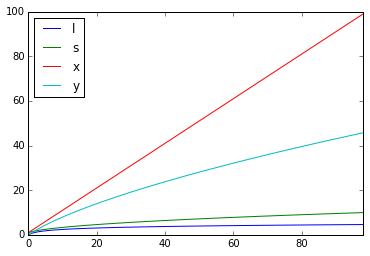

In [36]:
x = pd.Series(range(1,100))
y = np.sqrt(x)*np.log(x)
s = np.sqrt(x)
l = np.log(x)
df = pd.DataFrame({'x':x,'y':y,'s':s,'l':l})
df.plot()

In [129]:
%%cython -a
import copy

def make_board(n=7):
    board = set(range(1,n+1))
    return board

cdef class FastGameNode:
    cdef int sums[3]
    cdef int movein_player, moveout_player
    cdef set board
    cdef int level
    
    def __init__(self, movein_player=2, board=make_board(), level=0):
        self.sums[0] = sum(board)
        self.sums[1] = 0
        self.sums[2] = 0    
        self.movein_player = movein_player
        self.moveout_player = 3-movein_player
        self.board = board
        self.level = level
                
    cdef void push_move(self, list move):
        # this is used for modifying a GameNode to a new state if you don't care about building a complete tree
        
        # swap in/out players
        self.movein_player, self.moveout_player = self.moveout_player, self.movein_player
        self.level += 1
        cdef int m
        for m in move:
            self.board.discard(m)
            self.sums[self.movein_player] += m
            self.sums[0] -= m

    cdef void pop_move(self, list move):
        # this is used for modifying a GameNode to a new state if you don't care about building a complete tree
        
        # swap in/out players
        self.movein_player, self.moveout_player = self.moveout_player, self.movein_player
        self.level -= 1
        cdef int m
        for m in move:
            self.board.add(m)
            self.sums[self.moveout_player] -= m
            self.sums[0] += m
        
    cdef str make_key(self, str extra=""):
        return "%d:%d/%d:%s:%s" % (self.movein_player, self.sums[1], self.sums[2], str(self.board), extra)

    cdef int scoreP1(self):
        cdef int sA = self.sums[1]
        cdef int sB = self.sums[2]
        return sA-sB
    
    cdef int win(self):
        cdef int s = self.score()
        if s < 0:
            return -1
        elif s > 0:
            return 1
        else:
            return 0
    
    cdef int winP1(self):
        cdef int s = self.scoreP1()
        if s < 0:
            return -1
        elif s > 0:
            return 1
        else:
            return 0
    
    cdef int score(self):
        cdef int sA = self.sums[self.movein_player]
        cdef int sB = self.sums[self.moveout_player]
        return sA-sB

    def generate_move(self, maxplay, sum_move, move, picks):
        cdef int maxpick
        cdef int csum_move = sum_move
        cdef int cmaxplay = maxplay
        
        if move:
            maxpick = max(move)
        else:
            maxpick = 0
            
        cdef int len_move_plus_1 = len(move)+1
        cdef int len_picks = len(picks)
        cdef int pick

        for pick in picks:
            if pick < maxpick:
                # only emit the moves in increasing order 
                # (i.e don't emit both 2,3 and 3,2 if you are behind by 4, just emit 2,3)
                continue

            if pick in move:
                # can't pick something you've already picked
                continue

            move.append(pick)
            if len_move_plus_1 == len_picks:
                yield list(move)
            elif csum_move+pick >= cmaxplay:
                yield list(move)
            else:
                for m in self.generate_move(cmaxplay, csum_move+pick, move, picks):
                    yield m
            move.pop()
    
    cdef int gameover(self):
        return self.sums[0] == 0
    
    def possible_moves(self):
        # A is the current player
        # B is the opponent player
        cdef int sA = self.sums[self.moveout_player]
        cdef int sB = self.sums[self.movein_player]

        cdef int maxplay = sB - sA
        #assert maxplay >= 0

        moves = list(self.generate_move(maxplay, 0, [], self.board))
        return moves
      
        
cdef int _FastMinDepth_explore(FastGameNode node, int depth, int maxdepth, dict cache):
    #if depth >= maxdepth:
    #    return maxdepth+1

    key = node.make_key(str(depth))
    if cache.has_key(key):
        return cache[key]
    
    if node.gameover():
        # found a game that ends at depth, we are done
        cache[key] = depth
        return depth           
    elif depth+1 <= maxdepth:
        # haven't reached the maxdepth yet, keep looking
        moves = node.possible_moves()
        for move in moves:
            node.push_move(move)
            best = _FastMinDepth_explore(node, depth+1, maxdepth, cache)
            node.pop_move(move)

            if best <= maxdepth:
                cache[key] = best
                return best
        # if here, we didn't find anything
        cache[key] = maxdepth+1
        return maxdepth+1
    else:
        # fail case, truncating
        cache[key] = maxdepth+1
        return maxdepth+1


def FastMinDepth(n=10, start=None, end=None):
    # use iterative deepening
    cdef FastGameNode root = FastGameNode(board=make_board(n))
    cdef dict cache = {}
    
    if start == None:
        start = 1
    if end == None:
        end = n

    cdef int iterdepth
    cdef int v
    for iterdepth in xrange(start, end+1):
        cache = {}
        v = _FastMinDepth_explore(root, 0, iterdepth, cache)
        if v <= iterdepth:
            return v

    return -1
    
cdef void _explore_FastUniqueStates(FastGameNode node, dict cache):
    cdef str key = node.make_key()
    if cache.has_key(key):
        return
    else:
        cache[key] = 1
        cache['TOTAL'] += 1

    cdef list moves = node.possible_moves()
    cdef list move
    if not moves:
        return 
    else:
        for move in moves:
            node.push_move(move)
            _explore_FastUniqueStates(node, cache)
            node.pop_move(move)

def FastUniqueStates(n=8):
    cdef dict cache = {'TOTAL':0}
    cdef FastGameNode root = FastGameNode(board=make_board(n))
   
    _explore_FastUniqueStates(root, cache)
        
    return cache['TOTAL']

cdef int _explore_FastNegamax(FastGameNode node, int depth, int color, dict cache):
    #node.show2()
    cdef str key = node.make_key()
    if cache.has_key(key):
        return cache[key]

    if depth == 0:
        cache[key] = color * node.winP1()
        return color * node.winP1()
    
    cdef list moves = node.possible_moves()
    if not moves:
        cache[key] = color * node.winP1()
        return color * node.winP1()

    cdef int bestValue = -100
    cdef int val
    
    for move in moves:
        node.push_move(move)
        val = -_explore_FastNegamax(node, depth-1, -color, cache)
        node.pop_move(move)
        bestValue = max( bestValue, val )
        # can't get any better than 1
        if bestValue == 1:
            break
    cache[key] = bestValue
    return bestValue


def FastNegamax(n=8):
    cdef FastGameNode root = FastGameNode(board=make_board(n))

    # negamax code ported from https://en.wikipedia.org/wiki/Negamax
    cache = {}
        
    return _explore_FastNegamax(root, n+1, 1, cache)


    

    

In [127]:
FastMinDepth(13)

5

In [130]:
FastMinDepth(17, start=6, end=6)

6

In [401]:
%timeit FastNegamax(10)
#%time FastTreeExplore(10).negamax_cached()

100 loops, best of 3: 11.9 ms per loop


In [ ]:
t = FastTreeExplore(11)
%time a = t.mindepth_id()
%time b = FastMinDepth(11)
%time c = t.mindepth()
(a,b,c)

In [9]:
t = FastTreeExplore(4)


In [ ]:
t = FastTreeExplore(14)
%time a = t.mindepth_id2()
a

In [ ]:
nmin = 3
nmax = 20
n = nmin
v = 1
mindepths = []
while n <= nmax:
    %time v = FastMinDepth(n, start = v)
    print(n, v)
    mindepths.append(v)
    n += 1
    
mindepths = pd.DataFrame({'n':range(nmin,nmax+1), 'mindepth':mindepths})
mindepths.index = range(nmin,nmax+1)
mindepths

CPU times: user 61 µs, sys: 0 ns, total: 61 µs
Wall time: 65.1 µs
(3, 2)
CPU times: user 90 µs, sys: 3 µs, total: 93 µs
Wall time: 93.9 µs
(4, 2)
CPU times: user 290 µs, sys: 7 µs, total: 297 µs
Wall time: 306 µs
(5, 3)
CPU times: user 546 µs, sys: 1 µs, total: 547 µs
Wall time: 549 µs
(6, 3)
CPU times: user 1.94 ms, sys: 1 µs, total: 1.94 ms
Wall time: 1.94 ms
(7, 3)
CPU times: user 12.1 ms, sys: 34 µs, total: 12.1 ms
Wall time: 12.1 ms
(8, 4)
CPU times: user 22.6 ms, sys: 29 µs, total: 22.6 ms
Wall time: 22.6 ms
(9, 4)
CPU times: user 89.5 ms, sys: 1.43 ms, total: 90.9 ms
Wall time: 91.2 ms
(10, 4)
CPU times: user 594 ms, sys: 2.35 ms, total: 596 ms
Wall time: 597 ms
(11, 5)
CPU times: user 926 ms, sys: 2.92 ms, total: 929 ms
Wall time: 930 ms
(12, 5)
CPU times: user 3.41 s, sys: 6.39 ms, total: 3.41 s
Wall time: 3.42 s
(13, 5)
CPU times: user 19.2 s, sys: 77.4 ms, total: 19.3 s
Wall time: 19.4 s
(14, 6)
CPU times: user 30 s, sys: 98.9 ms, total: 30 s

In [95]:
class TreeBuilder:
    def __init__(self, n=4, build=False):
        self.root = GameNode(board=make_board(n))
        self.next_vertexid = 0
        self.cache = {}
        if build == True:
            self.build()
            self.calc_results()
            
    def find_node(self, board, player, score):
        def _find(node):
            if board == node.board and node.moveout_player and node.score() == score:
                print(node.movein)
                return node

            # early exit if we are searching for something that has already been removed
            for needle in board:
                if needle not in node.board:
                    return None
                
            # search all children
            for child in node.children:
                found = _find(child)
                if found:
                    print(node.movein)
                    return found
                
            # nothing found
            return None
        
        return _find(self.root)
    
    def num_states(self):
        def _recurse(node):
            n = 1 # count 1 for the note
            for child in node.children:
                n += _recurse(child)
            return n
        return _recurse(self.root)
            
            
    def build(self, cache=True):
        def _step_cached(node):
            key = node.make_key()
            
            node.setmoves()
            for move in node.moves:
                child = node.make_move(move)
                key = child.make_key()
                if self.cache.has_key(key):
                    # we've already been down this path on a previous branch, so we can skip it
                    node.children.pop()
                    node.children.append(self.cache[key])
                else:
                    self.cache[key] = child
                    _step_cached(child)
                
        def _step_uncached(node):
            node.setmoves()
            for move in node.moves:
                node.make_move(move)

            for child in node.children:
                _step_uncached(child)
                                
        if cache:
            self.cache = {}
            _step_cached(self.root)
        else:
            _step_uncached(self.root)
        
    def make_graph(self, startnode=None, trimdepth=-1):
        g = igraph.Graph()
        
        if startnode == None:
            startnode = self.root
        
        self.next_vertexid = 0
        self.assign_vertexids(startnode)
        g.add_vertices(self.next_vertexid)
        
        edgelist, attrlist = self.assign_edges(startnode, [], [])
        g.add_edges(edgelist)
        
        self.setup_vertex_attributes(g, startnode)
        self.setup_edge_attributes(g, edgelist, attrlist)
                
        
        if trimdepth > 0:
            to_delete_ids = [v.index for v in g.vs if v['depth'] >= trimdepth]
            g.delete_vertices(to_delete_ids)
        return g
    
    def setup_vertex_attributes(self, g, node):
        v = g.vs[node.vertexid]
        
        v['size'] = 10
        
        if node.moveout_player == 1:
            v['shape'] = 'triangle-up'
        else:
            v['shape'] = 'square'

        board = [str(b) for b in node.board]
        text = '{' + ','.join(board) + '}:'+str(abs(node.scoreP1()))
        v['label'] = text
        #v['label'] = ""
        
        v['depth'] = node.level

        v['label_size'] = 8
        v['label_dist'] = 2
        v['label_angle'] = 3.14/2

        if -node.result == 0:
            v['color'] = '#CCCCCC'
        elif -node.result > 0:
            v['color'] = '#FFBF00'
        else:
            v['color'] = 'red'
            
        for child in node.children:
            self.setup_vertex_attributes(g, child)
    
    def setup_edge_attributes(self, g, edgelist, attrlist):
        i=0
        for attrs in attrlist:
            e = g.es[i]
            e['color'] = attrs[0]
            e['label'] = attrs[1]
            e['label_size'] = 8
            i+=1
            
    
    def assign_edges(self, node, inlist=[], attrlist=[]):
        if node.graphed:
            return inlist, attrlist
        
        node.graphed = True
        
        for i, child in enumerate(node.children):
            inlist.append((node.vertexid, child.vertexid))
                    
            if child.result == 0:
                color = '#888888'
            elif child.result < 0:
                color = 'red'
            else:
                color = '#e5ab00'
                
            move = [str(m) for m in node.moves[i]]
            label = ','.join(move)
            #label = ""
        
            attrlist.append((color, label))
                
        for child in node.children:
            self.assign_edges(child, inlist, attrlist)
        return inlist, attrlist
    
    def assign_vertexids(self, node):
        if node.vertexid == None:
            node.vertexid = self.next_vertexid
            self.next_vertexid += 1

            for child in node.children:
                self.assign_vertexids(child)
        
    def calc_results(self):
        self.calc_results_recursive(self.root)
    
    def calc_results_recursive(self, node):
        if node.result != None:
            # we've already calculated the result for this node (since we might have cyclic trees)
            return
        
        if not node.children:
            # terminal node
            node.result = node.win()
        else:
            # has children
            for child in node.children:
                self.calc_results_recursive(child)
            child_results = [child.result for child in node.children]
            node.result = -max(child_results)
           
    def calc_sg(self):
        def _explore(node):
            if node.sgvalue != None:
                # we've already calculated the sgvalue
                return
            if not node.children:
                node.sgvalue = 0

    def step(self, node):
        node.setmoves()
        for move in node.moves:
            node.make_move(move)
            
            

In [96]:
def Go(n=5, cache=True):
    t = TreeBuilder(n)
    %time t.build(cache=cache)
    %time t.calc_results()
    
Go(12)


KeyboardInterrupt: 

## Game Tree Size

According to the wikipedia page on [Game complexity](https://en.wikipedia.org/wiki/Game_complexity), "The *game tree size* is the total number of possible games that can be played: the number of leaf nodes in the game tree rooted at the game's initial position."

In [15]:
n = 1
nmax = 20
nterminals = []
while n <= nmax:
    tree = FastTreeExplore(n)
    v = tree.num_terminals_cached()
    print(n, v)
    nterminals.append(v)
    n += 1
    
nterminals = pd.DataFrame({'n':range(1,nmax+1), 'treesize':nterminals})
nterminals.index = range(1,nmax+1)
nterminals

(1, 1)
(2, 2)
(3, 5)
(4, 20)
(5, 96)
(6, 520)
(7, 3306)
(8, 24250)
(9, 201992)
(10, 1841025)
(11, 18340537)
(12, 200456903)
(13, 2383675507)
(14, 30336710427)
(15, 411882282216)
(16, 5985285003470)
(17, 92666490774058)
(18, 1513557560255886)
(19, 26021545074879136)
(20, 471976580061531713)


,n,treesize
1,1,1
2,2,2
3,3,5
4,4,20
5,5,96
6,6,520
7,7,3306
8,8,24250
9,9,201992
10,10,1841025


## State Space Complexity
this is the number of unique states that the game can be in.  we can ignore the moves that took us to the current state, and just look at the board selection, active player, and current score.

In [29]:
%prun FastTreeExplore(12).unique_states()


In [26]:
%time FastUniqueStates(13)

CPU times: user 6.09 s, sys: 11.6 ms, total: 6.11 s
Wall time: 6.11 s


95126

In [30]:
n = 1
nmax = 20
nterminals = []
while n <= nmax:
    %time v = FastUniqueStates(n)
    print(n, v)
    nterminals.append(v)
    n += 1
    
nterminals = pd.DataFrame({'n':range(1,nmax+1), 'treesize':nterminals})
nterminals.index = range(1,nmax+1)
nterminals


CPU times: user 27 µs, sys: 0 ns, total: 27 µs
Wall time: 31 µs
(1, 2)
CPU times: user 35 µs, sys: 2 µs, total: 37 µs
Wall time: 37 µs
(2, 5)
CPU times: user 68 µs, sys: 2 µs, total: 70 µs
Wall time: 72 µs
(3, 11)
CPU times: user 195 µs, sys: 1e+03 ns, total: 196 µs
Wall time: 198 µs
(4, 33)
CPU times: user 652 µs, sys: 0 ns, total: 652 µs
Wall time: 654 µs
(5, 90)
CPU times: user 2.15 ms, sys: 2 µs, total: 2.15 ms
Wall time: 2.15 ms
(6, 236)
CPU times: user 7.17 ms, sys: 4 µs, total: 7.17 ms
Wall time: 7.17 ms
(7, 591)
CPU times: user 23.5 ms, sys: 26 µs, total: 23.5 ms
Wall time: 23.5 ms
(8, 1453)
CPU times: user 77.6 ms, sys: 271 µs, total: 77.9 ms
Wall time: 78.2 ms
(9, 3484)
CPU times: user 224 ms, sys: 452 µs, total: 224 ms
Wall time: 224 ms
(10, 8174)
CPU times: user 734 ms, sys: 787 µs, total: 735 ms
Wall time: 735 ms
(11, 18799)
CPU times: user 2.18 s, sys: 7.16 ms, total: 2.19 s
Wall time: 2.2 s
(12, 42587)
CPU times: user 6.56 s, sys: 14 ms, total: 6.58 s
Wall time: 6.59 s
(

,n,treesize
1,1,2
2,2,5
3,3,11
4,4,33
5,5,90
6,6,236
7,7,591
8,8,1453
9,9,3484
10,10,8174


## Game Depth
what are the minimum and maximum depths for a game with board $1...N$?

In [ ]:
t = FastTreeExplore(11)
#%prun t.mindepth_bfs()
#%time t.mindepth()


In [ ]:
nmax=10
trees = [FastTreeExplore(n) for n in xrange(1,nmax+1)]
s = pd.Series([tree.mindepth() for tree in trees])
s.index = range(1,nmax+1)
s

In [96]:
def make_tree_image(filename, n, bbox, trimdepth=-1, treetype="tree", cache=False):
    t = TreeBuilder(n)
    t.build(cache=cache)
    t.calc_results()
    #t.root.show(recursive=True)
    g = t.make_graph(trimdepth=trimdepth)
    if treetype == 'tree' or treetype=='rt_circular':
        layout = g.layout(treetype,root=[0])
    else:
        layout = g.layout(treetype)
    igraph.plot(g, filename, bbox=bbox, layout=layout)

In [86]:
def make_subtree_image(filename, n, bbox, board, player, scorediff, trimdepth=-1, treetype="tree", cache=False):
    t = TreeBuilder(n)
    t.build(cache=cache)
    t.calc_results()
    #t.root.show(recursive=True)
    node = t.find_node(board, player, scorediff)
    g = t.make_graph(startnode= node, trimdepth=trimdepth)
    if treetype == 'tree' or treetype=='rt_circular':
        layout = g.layout(treetype,root=[0])
    else:
        layout = g.layout(treetype)
    igraph.plot(g, filename, bbox=bbox, layout=layout)

In [97]:
make_subtree_image("subtree-comeback.pdf", 7, (0,0,500,200), set([3,4,7]), 1, 2)

[6]
[5]
[2]
[1]
[]


In [102]:
make_subtree_image("subtree-dangerous.pdf", 7, (0,0,600,250), set([1,2,4,7]), 2, 4)

[6]
[5]
[3]
[]


In [106]:
make_subtree_image("subtree-dangerous2.pdf", 7, (0,0,600,275), set([1,3,4,6]), 2, 4)

[7]
[5]
[2]
[]


In [97]:
make_tree_image("cycle-tree-4.pdf", 4, (0,0,1000,1000), treetype = "auto", cache=True)

In [226]:
make_tree_image("full-tree-4.pdf", 4, (0,0,2000,600))
make_tree_image("full-tree-5.pdf", 5, (0,0,2500,600))
make_tree_image("full-tree-6.pdf", 6, (0,0,20000,600))
make_tree_image("full-tree-7.pdf", 7, (0,0,64000,600))

In [80]:
make_tree_image("paper/tree-4.pdf", 4, (0,0,1000,300))

In [235]:
make_tree_image("tree-7-trunc3.pdf", 7, (0,0,8000,8000), 8, "rt_circular")

In [ ]:
nmax=9
trees = [TreeBuilder(n, build=True) for n in xrange(1,nmax+1)]
nstates = pd.Series([tree.num_states() for tree in trees])
nstates.index = range(1,nmax+1)
nstates


In [ ]:
test = pd.DataFrame({'nstates':nstates})
test['nlogn'] = [n*np.log(n) for n in test.index]
test['lognstates'] = np.log(test['nstates'])
test.plot(x='nlogn', y='lognstates')
#test


## Optimal Play

For N, solve the optimal play using a cached negamax.

In [394]:
def SolveGame(n=8):
    t = TreeBuilder(n)
    t.build()
    t.calc_results()
    return -t.root.result

%time print(FastNegamax(13))
%time FastTreeExplore(13).negamax_cached()

1
CPU times: user 6.12 s, sys: 17 ms, total: 6.14 s
Wall time: 6.14 s
CPU times: user 11.4 s, sys: 19.6 ms, total: 11.4 s
Wall time: 11.4 s


1

In [410]:
ranges = range(3,20)
df = pd.DataFrame(columns=['n','winP1'])
df['n'] = ranges
df['winP1'] = pd.Series([FastNegamax(n) for n in ranges])
df

,n,winP1
0,3,0
1,4,0
2,5,1
3,6,1
4,7,0
5,8,0
6,9,-1
7,10,-1
8,11,0
9,12,0


In [125]:
g = GameNode(board=make_board(17))
g.push_move([17])

moves = g.possible_moves()
assert [7,9,16] in moves
g.push_move([7,9,16])

moves = g.possible_moves()
assert [6,8,15] in moves
g.push_move([6,8,15])

moves = g.possible_moves()
assert [3,10,14] in moves
g.push_move([3,10,14])

moves = g.possible_moves()
assert [1,11,13] in moves
g.push_move([1,11,13])

g.board

{2, 4, 5, 12}